In [2]:
import jax
import jax.numpy as jnp
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.metrics import confusion_matrix
import seaborn as sns
from sklearn.preprocessing import StandardScaler


In [3]:
#import our data
column_names = [
    "ID", "Diagnosis", 
    "Mean Radius", "Mean Texture", "Mean Perimeter", "Mean Area", "Mean Smoothness",
    "Mean Compactness", "Mean Concavity", "Mean Concave Points", "Mean Symmetry", "Mean Fractal Dimension",
    "Radius SE", "Texture SE", "Perimeter SE", "Area SE", "Smoothness SE",
    "Compactness SE", "Concavity SE", "Concave Points SE", "Symmetry SE", "Fractal Dimension SE",
    "Worst Radius", "Worst Texture", "Worst Perimeter", "Worst Area", "Worst Smoothness",
    "Worst Compactness", "Worst Concavity", "Worst Concave Points", "Worst Symmetry", "Worst Fractal Dimension"
]

data = pd.read_csv('../data/wdbc.data')
n_feat = 30
data.columns = column_names

data['Diagnosis'] = data['Diagnosis'].map({'M': 1, 'B': 0})  # Convert M to 1, B to 0

df_numeric = data.drop(columns=['ID'], errors='ignore')
x = data.iloc[:, 2:].values
y = data.iloc[:, 1].values

total_samples = len(x)
train_size = int(total_samples * 0.8)
val_size = int(total_samples * 0.1)


X_train = x[:train_size]
y_train = y[:train_size]
X_val = x[train_size:train_size+val_size]
y_val = y[train_size:train_size+val_size]


X_test = x[train_size+val_size:]
y_test = y[train_size+val_size:]


In [4]:
# Build our neural network layers

# sigmoid activation for our output layer
def sigmoid_layer(sig_w,x):
    #using jax operations: jnp.dot(x,w)
    ex = jnp.exp(-jnp.dot(x, sig_w))
    
    return 1/(1 + ex)

#For Hidden Layers
def ReLu(x):
    return jnp.maximum(0, x)


# linear activation for our output layer (for a regression model)
def linear(lin_w,inputs):
    return jnp.dot(inputs, lin_w)


def nn_model(ws, x):
    w_relu1 = ws[0]
    w_relu2 = ws[1]
    w_relu3 = ws[2]
    w_sig = ws[3]
    
    hidden_1 = ReLu(jnp.dot(x, w_relu1))
    hidden_2 = ReLu(jnp.dot(hidden_1, w_relu2))
    hidden_3 = ReLu(jnp.dot(hidden_2, w_relu3))

    y_pred = sigmoid_layer(w_sig, hidden_3)
    
    return y_pred


# Define the binary cross entropy function 
def nn_loss(w,x,y):
    y_pred = nn_model(w,x)
    # Add small epsilon to prevent log(0)
    epsilon = 1e-7
    y_pred = jnp.clip(y_pred, epsilon, 1.0 - epsilon)
    loss_per_sample = -(y * jnp.log(y_pred) + (1 - y) * jnp.log(1 - y_pred))
    return jnp.mean(loss_per_sample)


# Define the gradient of the loss function
nn_loss_grad = jax.grad(nn_loss)

# Perform gradient descent to optimize the parameters
def nn_gradient_descent(w, xtrain, ytrain, xval, yval, learning_rate=.01, num_epochs=1000):
    w1, w2, w3, w4 = w

    loss_f = np.zeros(num_epochs)
    valloss_f = np.zeros(num_epochs)
    for i in range(num_epochs):
        grad_w1, grad_w2, grad_w3, grad_w4 = nn_loss_grad(w, xtrain, ytrain)

        clip_value = 5.0
        grad_w1 = jnp.clip(grad_w1, -clip_value, clip_value)
        grad_w2 = jnp.clip(grad_w2, -clip_value, clip_value)
        grad_w3 = jnp.clip(grad_w3, -clip_value, clip_value)
        grad_w4 = jnp.clip(grad_w4, -clip_value, clip_value)

        w1 = w1 - learning_rate * grad_w1
        w2 = w2 - learning_rate * grad_w2
        w3 = w3 - learning_rate * grad_w3
        w4 = w4 - learning_rate * grad_w4

        
        w = [w1,w2,w3,w4]
        

        loss_f[i] = nn_loss(w,xtrain,ytrain)
        valloss_f[i] = nn_loss(w,xval,yval)
        if i % 100 == 0:
            print(f"Epoch {i}: Train Loss = {loss_f[i]:.4f}, Val Loss = {valloss_f[i]:.4f}")

    return w, loss_f, valloss_f

Epoch 0: Train Loss = 0.6793, Val Loss = 0.6930
Epoch 100: Train Loss = 0.1043, Val Loss = 0.1238
Epoch 200: Train Loss = 0.0672, Val Loss = 0.0765
Epoch 300: Train Loss = 0.0536, Val Loss = 0.0637
Epoch 400: Train Loss = 0.0432, Val Loss = 0.0580
Epoch 500: Train Loss = 0.0352, Val Loss = 0.0561
Epoch 600: Train Loss = 0.0303, Val Loss = 0.0527
Epoch 700: Train Loss = 0.0255, Val Loss = 0.0553
Epoch 800: Train Loss = 0.0216, Val Loss = 0.0555
Epoch 900: Train Loss = 0.0181, Val Loss = 0.0572
Epoch 1000: Train Loss = 0.0155, Val Loss = 0.0577
Epoch 1100: Train Loss = 0.0133, Val Loss = 0.0558
Epoch 1200: Train Loss = 0.0114, Val Loss = 0.0556
Epoch 1300: Train Loss = 0.0098, Val Loss = 0.0524
Epoch 1400: Train Loss = 0.0084, Val Loss = 0.0493
Epoch 1500: Train Loss = 0.0074, Val Loss = 0.0468
Epoch 1600: Train Loss = 0.0065, Val Loss = 0.0456
Epoch 1700: Train Loss = 0.0058, Val Loss = 0.0446
Epoch 1800: Train Loss = 0.0052, Val Loss = 0.0434
Epoch 1900: Train Loss = 0.0047, Val Loss =

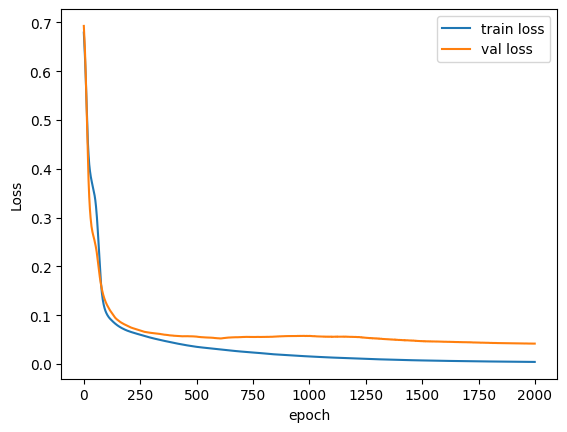

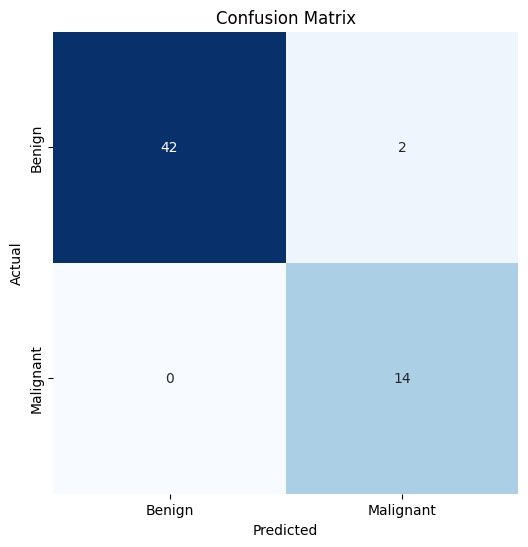

Accuracy: 96.55%


In [6]:

# Initialize parameters randomly
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)
X_test_scaled = scaler.transform(X_test)


main_key = jax.random.PRNGKey(22)
key1, key2, key3, key4 = jax.random.split(main_key, 4)

# Get number of features from training data directly
num_features = X_train.shape[1]

# Use different keys for each layer
w1 = jax.random.normal(key1, (num_features, 15)) * np.sqrt(2.0/num_features)
w2 = jax.random.normal(key2, (15, 10)) * np.sqrt(2.0/15)
w3 = jax.random.normal(key3, (10, 5)) * np.sqrt(2.0/10)
w4 = jax.random.normal(key4, (5,)) * np.sqrt(2.0/5)

w = [w1, w2, w3, w4]


output = nn_model(w, X_test_scaled)

# Perform gradient descent
w_result, lossf, val_lossf = nn_gradient_descent(w, X_train_scaled, y_train, X_val_scaled, y_val, learning_rate=.1, num_epochs=2000)
plt.plot(lossf, label="train loss")
plt.plot(val_lossf, label="val loss")
plt.xlabel("epoch")
plt.ylabel("Loss")
plt.legend()
plt.show()

predictions = nn_model(w_result, X_test_scaled)

binary_preds = (predictions > 0.5).astype(int)
cm = confusion_matrix(y_test, binary_preds)

plt.figure(figsize=(6, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False,
            xticklabels=['Benign', 'Malignant'],
            yticklabels=['Benign', 'Malignant'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()
print(f"Accuracy: {np.mean(binary_preds == y_test) * 100:.2f}%")

